In [1]:
# Run the installation of Python that's the same as the one running under the notebook: sys.executable
# because the python accessible from Linux console (!python) could be a different installation!
# Run these too to see if the current setup is affected from this: (then they are different)
import sys
!echo {sys.executable} 
!which python

/opt/conda/bin/python
/opt/conda/bin/python


In [ ]:
# Instead of opening a console, put some Linux commands starting with ! character
#!git clone https://github.com/Meta-optimization/L2L.git -b olive
# If the repo is already cloned, put a # to the above line to skip it

In [ ]:
# If you want to start over with the repo, delete the folder containing it (do keep your changes though first!)
#!rm -rf L2L

In [2]:
!pwd
!cd L2L; {sys.executable} setup.py install --user
# Note that 'cd' only affected that one command, it didn't affect the notebook's state
!pwd

/home/jovyan/work/ClassNora
/opt/conda/lib/python3.7/site-packages/setuptools/dist.py:454: UserWarning: Normalizing '1.0.0-beta' to '1.0.0b0'
  warnings.warn(tmpl.format(**locals()))
running install
running bdist_egg
running egg_info
writing Learning_to_Learn.egg-info/PKG-INFO
writing dependency_links to Learning_to_Learn.egg-info/dependency_links.txt
writing requirements to Learning_to_Learn.egg-info/requires.txt
writing top-level names to Learning_to_Learn.egg-info/top_level.txt
reading manifest file 'Learning_to_Learn.egg-info/SOURCES.txt'
writing manifest file 'Learning_to_Learn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/l2l
creating build/bdist.linux-x86_64/egg/l2l/tests
copying build/lib/l2l/tests/test_ce_optimizer.py -> build/bdist.linux-x86_64/egg/l2l/tests
copying build/lib/l2l/tests/test_gs_optimizer.py -> build/bdist.linux-x86_64

In [ ]:
# And uninstall with the appropriate command, as well 
# !{sys.executable} -m pip uninstall -y Learning-to-Learn

In [3]:
# Install JUBE: first put the tar-file in the L2L folder
!pwd
#!cd L2L; tar -xzvf JUBE-2.4.1.tar.gz
!cd L2L/JUBE-2.4.1; {sys.executable} setup.py install --user

/home/jovyan/work/ClassNora
running install
running bdist_egg
running egg_info
writing JUBE.egg-info/PKG-INFO
writing dependency_links to JUBE.egg-info/dependency_links.txt
writing requirements to JUBE.egg-info/requires.txt
writing top-level names to JUBE.egg-info/top_level.txt
reading manifest file 'JUBE.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'JUBE.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/jube2
copying build/lib/jube2/fileset.py -> build/bdist.linux-x86_64/egg/jube2
copying build/lib/jube2/benchmark.py -> build/bdist.linux-x86_64/egg/jube2
copying build/lib/jube2/parameter.py -> build/bdist.linux-x86_64/egg/jube2
copying build/lib/jube2/help.txt -> build/bdist.linux-x86_64/egg/jube2
copying build/lib/jube2/main.py -> build/bdist.linux-x86_64/egg/jube2
copying build/lib/jube2/completion.py -> b

In [4]:
import sys
sys.path.append("/home/jovyan/work/ClassNora/L2L")

In [5]:
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as pl

from l2l import sdict
from l2l.optimizees.optimizee import Optimizee
import ast

from pyneuroml import pynml
from pyneuroml.pynml import print_comment_v
from pyneuroml.lems import LEMSSimulation
import neuroml as nml
import neuroml.writers as writers
import neuroml.loaders as loaders
import neuroml.utils as utils
from neuroml.nml.nml import parse as nmlparse

import scipy.fftpack
from scipy.signal import find_peaks
from scipy import integrate

/opt/conda/lib/python3.7/site-packages/airspeed/__init__.py:505: FutureWarning: Possible nested set at position 8
  KEYVALSEP = re.compile(r'[ \t]*:[[ \t]*(.*)$', re.S)


In [33]:
import eden_tools

default_parameters = {'na_s_soma': 30,
            'kdr_soma': 30, 
            'k_soma': 15,
            'cal_soma': 20, 
            'cah_dend': 10,
            'kca_dend': 35,
            'h_dend': 25,
            'na_axon': 200,
            'k_axon': 200,
            'leak': 1.3e-2}

class SingleNeuronFit:
    def __init__(self, neuron_name, parameters = default_parameters, dt = 0.05):
        
        random.seed(12345)
        
        # inputs
        self.neuron_name = neuron_name
        
        #parameters and variables experimental part
        self.experimental_temp = 26
        
        #parameters and variables model part
        self.dt = dt #ms
        self.model_init_time = 500 #ms
        self.run_time = 1500 #ms
        self.ind_break = int(self.model_init_time/self.dt)+1
        self.LEMS_filename = " "
        self.results = {}
        self.model_current_signals = []
        self.model_voltage_signals = {}
        #self.model_time_axis = []
            
        #functions model part        
        self.run_network_with_Eden(default_parameters)
        
         
    def create_NML_network(self):
        # Create NeuroML file
        nml_doc = nml.NeuroMLDocument(id="net")

        # Include cell file
        incl = nml.IncludeType(href="C" + self.neuron_name[2:] + "_scaled_resample_5.cell.nml")
        nml_doc.includes.append(incl)

        # Create network
        net = nml.Network(id="net", type="networkWithTemperature", temperature=str(self.experimental_temp) + "degC")
        nml_doc.networks.append(net)

        # Create population
        comp_id = "C" + self.neuron_name[2:]
        pop = nml.Population(id="pop", component=comp_id, type="populationList", size="1")
        net.populations.append(pop)

        loc = nml.Location(x="0", y="0", z="0")

        inst = nml.Instance(id="0", location=loc)
        pop.instances.append(inst)

        nml_file = self.neuron_name[2:] + ".net.nml"
        writers.NeuroMLWriter.write(nml_doc, nml_file)

        nml_file_dir = os.path.dirname(os.path.realpath(nml_file))

        sim_id = self.neuron_name[2:]
        sim_dur_ms = self.model_init_time + self.run_time
        quantity = "pop/0/"+comp_id+"/0/v"
        target = 'net'

        ls = LEMSSimulation(sim_id, sim_dur_ms, self.dt, target=target)
        ls.include_neuroml2_file(nml_file)

        of0 = 'Volts_file'
        ls.create_output_file(of0, "%s.v.dat" % sim_id)
        ls.add_column_to_output_file(of0, 'v', quantity)

        self.LEMS_filename = "%s_simulation.xml" % sim_id
        ls.save_to_file(file_name=self.LEMS_filename)

    def run_network_with_Eden(self, parameters):
        self.change_condDensity(parameters["na_s_soma"], "na_s_soma")
        self.change_condDensity(parameters["kdr_soma"], "kdr_soma")
        self.change_condDensity(parameters["k_soma"], "k_soma")
        self.change_condDensity(parameters["cal_soma"], "cal_soma")
        self.change_condDensity(parameters["cah_dend"], "cah_dend")
        self.change_condDensity(parameters["kca_dend"], "kca_dend")
        self.change_condDensity(parameters["h_dend"], "h_dend")
        self.change_condDensity(parameters["na_axon"], "na_axon")
        self.change_condDensity(parameters["k_axon"], "k_axon")
        self.change_condDensity(parameters["leak"], "leak_all")
        
        self.create_NML_network()
        
        self.results = eden_tools.runEden(self.LEMS_filename, verbose=True)
        return self.results
        
    def change_condDensity(self, value, channel):
        # na_s_soma, kdr_soma, k_soma, cal_soma, cah_dend, kca_dend, h_dend, na_axon, k_axon, leak
        doc = nmlparse("C" + self.neuron_name[2:] + "_scaled_resample_5.cell.nml")
        channel_densities = doc.cells[0].biophysical_properties.membrane_properties.channel_densities
        nr_of_channels = len(channel_densities)
        for i in range(nr_of_channels):
            if channel_densities[i].id == channel:
                channel_densities[i].cond_density = str(value) + ' mS_per_cm2'
                #print("succesfully changed parameter value")
                break
            if i == nr_of_channels:
                print("channel not found; value was not changed")
        writers.NeuroMLWriter.write(doc, "C" + self.neuron_name[2:] + "_scaled_resample_5.cell.nml")

pyNeuroML >>> Written LEMS Simulation 160802D to file: 160802D_simulation.xml
Ran EDEN in 261.41 seconds
pyNeuroML >>> Reloading data specified in LEMS file: 160802D_simulation.xml (/home/jovyan/work/ClassNora/160802D_simulation.xml), base_dir: ., cwd: /home/jovyan/work/ClassNora
pyNeuroML >>> Written LEMS Simulation 160802D to file: 160802D_simulation.xml
Ran EDEN in 44.38 seconds
pyNeuroML >>> Reloading data specified in LEMS file: 160802D_simulation.xml (/home/jovyan/work/ClassNora/160802D_simulation.xml), base_dir: ., cwd: /home/jovyan/work/ClassNora
pyNeuroML >>> Written LEMS Simulation 160802D to file: 160802D_simulation.xml
Ran EDEN in 10.37 seconds
pyNeuroML >>> Reloading data specified in LEMS file: 160802D_simulation.xml (/home/jovyan/work/ClassNora/160802D_simulation.xml), base_dir: ., cwd: /home/jovyan/work/ClassNora
pyNeuroML >>> Written LEMS Simulation 160802D to file: 160802D_simulation.xml
Ran EDEN in 4.80 seconds
pyNeuroML >>> Reloading data specified in LEMS file: 160

Text(0,0.5,'v (V)')

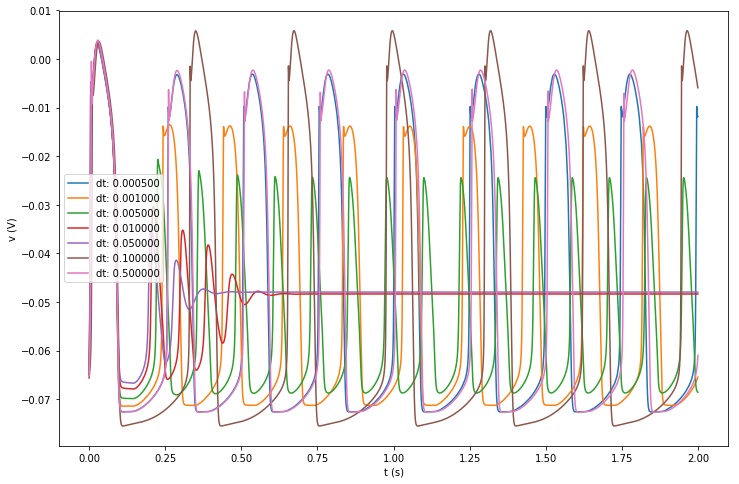

In [42]:
# Alper, you can skip this cell
neuron_name = '20160802D'
plt.figure()
for dtdt in [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]:
    snf = SingleNeuronFit(neuron_name, dt = dtdt)
    t = snf.results['t']
    v = snf.results['pop/0/C'+ neuron_name[2:] +'/0/v']
    plt.plot(t, v, label='dt: %f' %dtdt)
plt.legend()
plt.xlabel('t (s)')
plt.ylabel('v (V)')

In [14]:
import pkgutil

# this is the package we are inspecting -- for example 'email' from stdlib
import l2l.optimizers as opti

package = opti
for importer, modname, ispkg in pkgutil.iter_modules(package.__path__):
    print("Found submodule %s (is a package: %s)" % (modname, ispkg))

Found submodule crossentropy (is a package: True)
Found submodule evolution (is a package: True)
Found submodule evolutionstrategies (is a package: True)
Found submodule face (is a package: True)
Found submodule gradientdescent (is a package: True)
Found submodule gridsearch (is a package: True)
Found submodule naturalevolutionstrategies (is a package: True)
Found submodule optimizer (is a package: False)
Found submodule paralleltempering (is a package: True)
Found submodule simulatedannealing (is a package: True)


In [22]:
!cd L2L; {sys.executable} setup.py install --user --quiet
from l2l.utils.environment import Environment
from l2l.utils.experiment import Experiment
from l2l.optimizees.olive import NeuronOptimizee
from l2l.optimizers.evolution import GeneticAlgorithmOptimizer, GeneticAlgorithmParameters

parameters_dict = {}
fitness_dict = {}
n = 1

for i in range(n):
    experiment = Experiment(root_dir_path='/home/jovyan/work/ClassNora/results')
    jube_params = {"exec": "python"}
    traj, all_jube_params = experiment.prepare_experiment(name='L2L',
                                                          log_stdout=True,
                                                          jube_parameter=jube_params)
    optimizee = NeuronOptimizee(traj, seed = 12345)
    optimizer_parameters = GeneticAlgorithmParameters(seed = 12345,
                                                     popsize = 10,
                                                     CXPB = 0.5,
                                                     MUTPB = 0.2,
                                                     NGEN = 3,
                                                     indpb = 0.1,
                                                     tournsize = 3,
                                                     matepar = 0.2,
                                                     mutpar = 2)
    
    optimizer = GeneticAlgorithmOptimizer(traj, optimizee.create_individual, (1.0,),
                          optimizer_parameters)
    experiment.run_experiment(optimizee=optimizee,
                              optimizer=optimizer,
                              optimizer_parameters=optimizer_parameters)
    experiment.end_experiment(optimizer)
    
    parameters_dict[i] = traj._results['$set.$.individual']
    fitness_dict[i] = traj._results['$set.$.fitness']

/opt/conda/lib/python3.7/site-packages/setuptools/dist.py:454: UserWarning: Normalizing '1.0.0-beta' to '1.0.0b0'
  warnings.warn(tmpl.format(**locals()))
running install
running bdist_egg
running egg_info
writing Learning_to_Learn.egg-info/PKG-INFO
writing dependency_links to Learning_to_Learn.egg-info/dependency_links.txt
writing requirements to Learning_to_Learn.egg-info/requires.txt
writing top-level names to Learning_to_Learn.egg-info/top_level.txt
reading manifest file 'Learning_to_Learn.egg-info/SOURCES.txt'
writing manifest file 'Learning_to_Learn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
copying l2l/optimizees/olive/optimizee.py -> build/lib/l2l/optimizees/olive
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/l2l
creating build/bdist.linux-x86_64/egg/l2l/tests
copying build/lib/l2l/tests/test_ce_optimizer.py -> build/bdist.linux-x86_64/egg/l2l/tests
copying build/lib/l2l/tests/

INFO:root:Environment run starting JUBERunner for n iterations: 3



Running workpackages (#=done, 0=wait, E=error):
############################################################ ( 10/ 10)

INFO:root:Environment run starting JUBERunner for n iterations: 3




Best individual is {'cah_dend': 12.376209776688288, 'cal_soma': 10.740286312877958, 'h_dend': 34.86372539072677, 'k_axon': 368.52685841617637, 'k_soma': 27.8337571098825, 'kca_dend': 45.12839628586754, 'kdr_soma': 51.01666097664573, 'leak': 0.020701190516378788, 'na_axon': 115.58726353076008, 'na_s_soma': 16.2082174105471}, (-1.344860769195943,)
Best individual is {'cah_dend': 9.480555706540724, 'cal_soma': 13.193331300931579, 'h_dend': 42.86797072028506, 'k_axon': 389.39427921157903, 'k_soma': 7.688736703684953, 'kca_dend': 51.96158711181917, 'kdr_soma': 58.25880312327696, 'leak': 0.020611864264939092, 'na_axon': 361.65277411728493, 'na_s_soma': 48.64716641720732}, (-1.429259754634159,)

Running workpackages (#=done, 0=wait, E=error):
#######..................................................... (  1/  8)

KeyboardInterrupt: 

In [ ]:
#df = pd.DataFrame.from_dict(parameters_dict)
#df.to_pickle('parameters1.pkl')

In [46]:
voltageTrace_dict = {}

for i in range(n):
    parameters = parameters_dict[i]
    results = snf.run_network_with_Eden(parameters)
    voltageTrace_dict[i] = results['pop/0/C'+ neuron_name[2:] +'/0/v']

pyNeuroML >>> Written LEMS Simulation 160802D to file: 160802D_simulation.xml
Ran EDEN in 0.26 seconds
pyNeuroML >>> Reloading data specified in LEMS file: 160802D_simulation.xml (/home/jovyan/work/ClassNora/160802D_simulation.xml), base_dir: ., cwd: /home/jovyan/work/ClassNora


pyNeuroML >>> Written LEMS Simulation 160802D to file: 160802D_simulation.xml
Ran EDEN in 0.39 seconds
pyNeuroML >>> Reloading data specified in LEMS file: 160802D_simulation.xml (/home/jovyan/work/ClassNora/160802D_simulation.xml), base_dir: ., cwd: /home/jovyan/work/ClassNora


Text(0.5,0,'t (s)')

/opt/conda/lib/python3.7/site-packages/matplotlib/transforms.py:99: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jovyan/work/ClassNora/results/L2L/simulation/work/jobsystem_bench_142_0/stdout' mode='a' encoding='UTF-8'>
  self._parents = {}
/opt/conda/lib/python3.7/site-packages/matplotlib/transforms.py:99: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jovyan/work/ClassNora/results/L2L/simulation/work/jobsystem_bench_142_0/stderr' mode='a' encoding='UTF-8'>
  self._parents = {}
/opt/conda/lib/python3.7/site-packages/matplotlib/transforms.py:99: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jovyan/work/ClassNora/results/L2L/simulation/work/jobsystem_bench_148_1/stdout' mode='a' encoding='UTF-8'>
  self._parents = {}
/opt/conda/lib/python3.7/site-packages/matplotlib/transforms.py:99: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jovyan/work/ClassNora/results/L2L/simulation/work/jobsystem_bench_148_1/stderr' mode='a' encodin

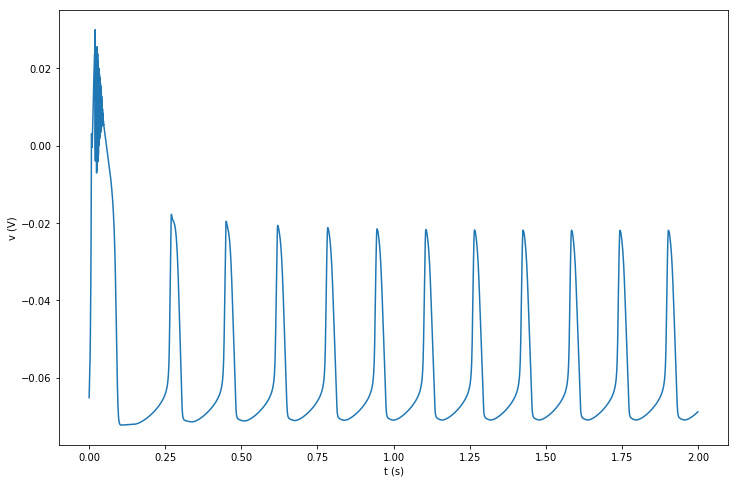

In [50]:
plt.rcParams['figure.figsize'] = [12, 8]

t = snf.results['t']
voltageTrace_dict = {}
plot_results = True
max_plots = 10
    
plt.figure()
j = 0
for i in range(n):
    if j < max_plots:
        parameters = parameters_dict[i]
        results = snf.run_network_with_Eden(parameters)
        voltageTrace_dict[i] = results['pop/0/C'+ neuron_name[2:] +'/0/v']
        plt.plot(t, voltageTrace_dict[i], label = 'fitness: %f' %fitness_dict[i])
    j += 1
plt.ylabel('v (V)')
plt.xlabel('t (s)')

/opt/conda/lib/python3.7/site-packages/matplotlib/axes/_base.py:3471: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-100, top=-100
  'bottom=%s, top=%s') % (bottom, top))


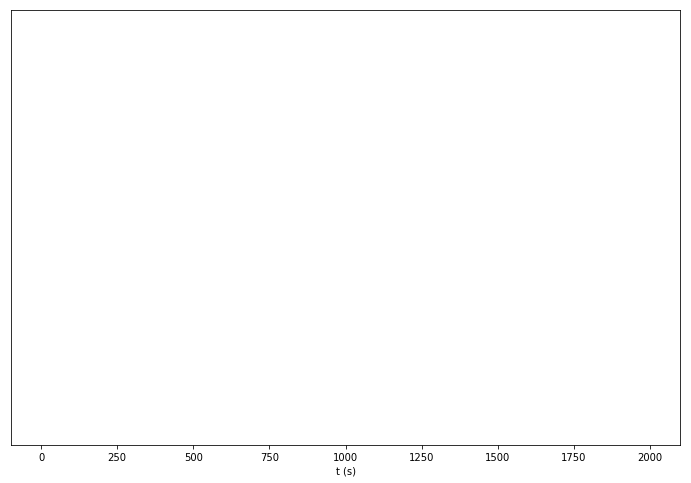

In [48]:
plt.rcParams['figure.figsize'] = [12, 8]

t = snf.results['t']
for i in voltageTrace_dict:
    v = voltageTrace_dict[i]
    #plt.plot([j * 1000 for j in t], [j * 1000 for j in v])
    plt.plot([j * 1000 for j in t], [j * 1000 + 100 * i for j in v], color='tab:blue')
plt.xlabel('t (s)')
#plt.xlim([500, 2000])
#plt.ylim([-80, 0])
plt.ylim([-100, 100 * i -100])
frame1 = plt.gca()
frame1.axes.get_yaxis().set_visible(False)
